In [1]:
""" (WGAN GP)
Wasserstein GAN with Gradient Penalties ('improved methods for WGAN training')

https://arxiv.org/pdf/1704.00028.pdf

Proposes a gradient penalty to add to the WGAN discriminator loss as an alternative method for enforcing 
the Lipschitz constraint (previously done via weight clipping). This penalty does not suffer from the biasing
of the discriminator toward simple funtions due to weight clipping. Additionally, the reformulation of the 
discriminator by adding a gradient penaltyterm makes batch normalization not necessary. This is notable because 
batch normalization implicitly changes the discriminator's problem from mapping one-to-one to many-to-many.

Note the relu in the discriminator instead of sigmoid.

"""
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from itertools import product
from load_data import get_data

def to_var(x):
    """ function to automatically cudarize.. """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Load in data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

In [2]:
class Generator(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        """ Generator. Input is noise, output is a generated image. """
        super(Generator, self).__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation
        
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_dim, output_dim):
        """ Critic (not trained to classify). Input is an image (real or generated), output is the approximate Wasserstein Distance between z~P(G(z)) and real. """
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.relu(self.discriminate(activated))
        return discrimination
    
class WGANGP(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim, output_dim = 1):
        """ Super class to contain both Discriminator / Critic (D) and Generator (G) """
        super(WGANGP, self).__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim
    
class Trainer:
    def __init__(self, train_iter, val_iter, test_iter):
        """ Object to hold data iterators, train a GAN variant """
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
    
    def train(self, model, num_epochs, G_lr = 1e-4, D_lr = 1e-4, D_steps = 5):
        """ Train a Wasserstein GAN with Gradient Penalty
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            model: initialized GAN module instance
            num_epochs: int, number of epochs to train for
            G_lr: learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: training step ratio for how often to train D compared to G (default 5)
        Outputs:
            model: trained WGANGP instance """
        
        # Adam optimizers
        G_optimizer = torch.optim.Adam(params=[p for p in model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.Adam(params=[p for p in model.D.parameters() if p.requires_grad], lr=D_lr)
        
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        for epoch in tqdm_notebook(range(1, num_epochs + 1)):
            model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                # TRAINING D: Train D for D_steps 
                for _ in range(D_steps):
                    
                    # Retrieve batch
                    images = self.process_batch(self.train_iter)

                    # Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator to learn to approximate the Wasserstein distance between real and generated distributions
                    D_loss = self.train_D(model, images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Save relevant output for progress logging, clamp weights
                    D_step_loss.append(D_loss)
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G. 
                G_optimizer.zero_grad()

                # Train the generator to (roughly) minimize the approximated Wasserstein distance
                G_loss = self.train_G(model, images)

                # Update parameters
                G_loss.backward()
                G_optimizer.step()

                # Save relevant output for progress logging
                G_losses.append(G_loss)
                
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses)))
            
            # Visualize generator progress
            fig = self.generate_images(model, epoch)
            plt.show()
            
        return model
    
    def train_D(self, model, images, LAMBDA = 10):
        """ Run 1 step of training for discriminator

        Input:
            model: model instantiation
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: wasserstein loss for discriminator, -E[D(x)] + E[D(G(z))] + λE[(||∇ D(εx + (1 − εG(z)))|| - 1)^2]
        """   
        
        # ORIGINAL CRITIC STEPS:
        # Sample noise, an output from the generator
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = model.G(noise)
        
        # Use the discriminator to sample real, generated images
        DX_score = model.D(images) # D(z)
        DG_score = model.D(G_output) # D(G(z))
        
        # GRADIENT PENALTY:
        # Uniformly sample along one straight line per each batch entry. 
        epsilon = torch.rand(images.shape[0], 1).expand(images.size())

        # Generate images from the noise, ensure unit gradient norm 1 (compared to TensorFlow original implementation this is foiled out)
        # See Section 4 and Algorithm 1 of original paper for full explanation.
        G_interpolation = to_var(epsilon*images.data + ((1-epsilon)*G_output.data)) # negation doesn't matter; we square later on
        G_interpolation.requires_grad = True

        D_interpolation = model.D(G_interpolation)

        # Compute the gradients of D with respect to the noise generated input
        gradients = torch.autograd.grad(outputs = D_interpolation, 
                            inputs = G_interpolation,
                            grad_outputs = torch.ones(D_interpolation.size()), # TODO: cuda
                            only_inputs = True,
                            create_graph = True,
                            retain_graph = True,)[0]

        # Full gradient penalty
        grad_penalty = LAMBDA * torch.mean((gradients.norm(2, dim = 1) - 1) **2)
        
        # Compute WGAN-GP loss for D
        D_loss = torch.mean(DG_score) - torch.mean(DX_score) + grad_penalty
        
        return D_loss
    
    def train_G(self, model, images):
        """ Run 1 step of training for generator
        
        Input:
            model: instantiated GAN
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: wasserstein loss for generator, -E[D(G(z))]
        """   
        # Get noise, classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], model.z_dim) # z
        G_output = model.G(noise) # G(z)
        DG_score = model.D(G_output) # D(G(z))
        
        # Compute WGAN-GP loss for G (same loss as WGAN)
        G_loss = -(torch.mean(DG_score))
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_var(torch.randn(batch_size, z_dim))
    
    def generate_images(self, model, epoch, num_outputs = 25, save = True):
        """ Visualize progress of generator learning """
        noise = self.compute_noise(num_outputs, model.z_dim)
        images = model.G(noise)
        images = images.view(images.shape[0], 28, 28)
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        if save:
            if not os.path.exists('../viz/wgp-gan/'):
                os.makedirs('../viz/wgp-gan/')
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), '../viz/wgp-gan/reconst_%d.png' %(epoch), nrow = 5)
        return fig
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_var(images.view(images.shape[0], -1))
        return images

    def save_model(self, model, savepath):
        """ Save model state dictionary """
        torch.save(model.state_dict(), savepath + 'saved_gan.pth')
    
    def load_model(self, loadpath,  model = None):
        """ Load state dictionary into model. If model not specified, instantiate it """
        if not model:
            model = WGANGP()
        state = torch.load(loadpath)
        model.load_state_dict(state)
        return model

Epoch[1/25], G Loss: 12.2664, D Loss: -9.5124


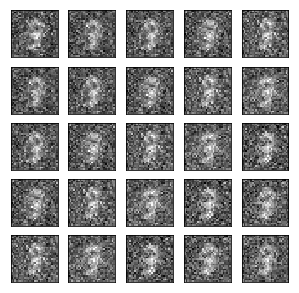

Epoch[2/25], G Loss: 7.6137, D Loss: -6.5598


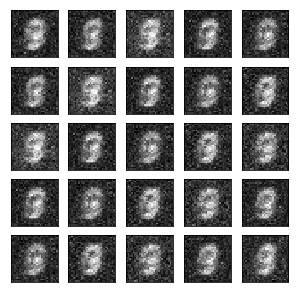

Epoch[3/25], G Loss: 3.1753, D Loss: -4.4302


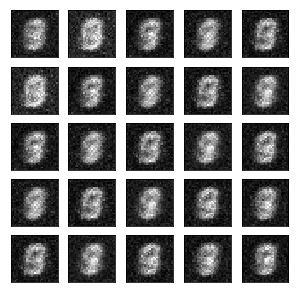

Epoch[4/25], G Loss: 1.0138, D Loss: -4.0327


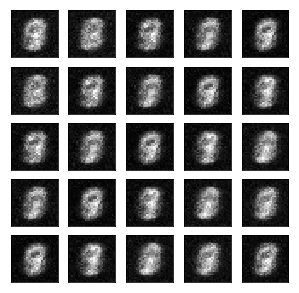

Epoch[5/25], G Loss: 0.0674, D Loss: -3.8621


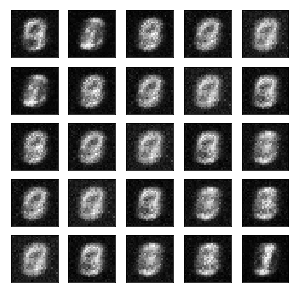

Epoch[6/25], G Loss: -0.4223, D Loss: -3.6136


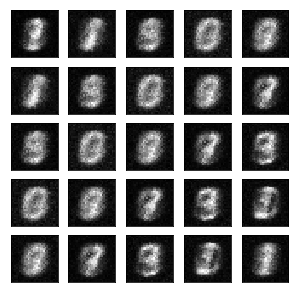

Epoch[7/25], G Loss: -0.7346, D Loss: -3.4600


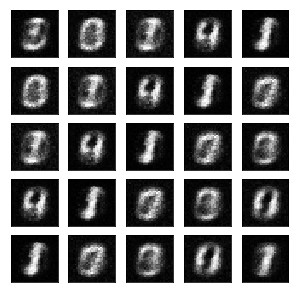

Epoch[8/25], G Loss: -0.9274, D Loss: -3.3551


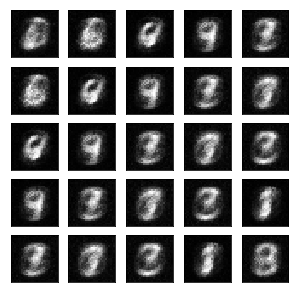

Epoch[9/25], G Loss: -1.0124, D Loss: -3.2146


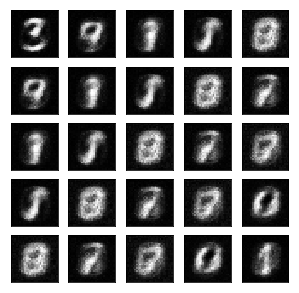

Epoch[10/25], G Loss: -1.0705, D Loss: -3.1020


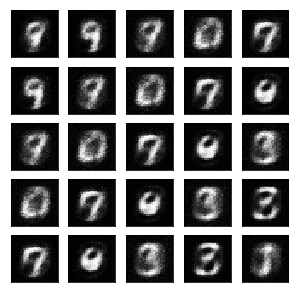

Epoch[11/25], G Loss: -1.1370, D Loss: -2.9818


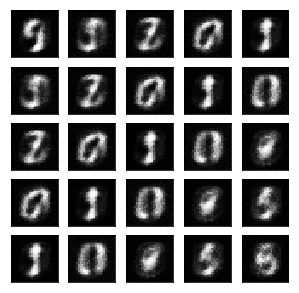

Epoch[12/25], G Loss: -1.1808, D Loss: -2.8483


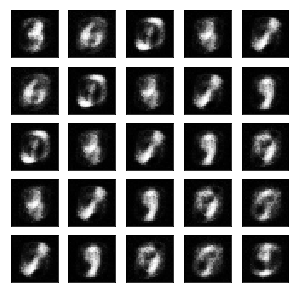

Epoch[13/25], G Loss: -1.2271, D Loss: -2.7004


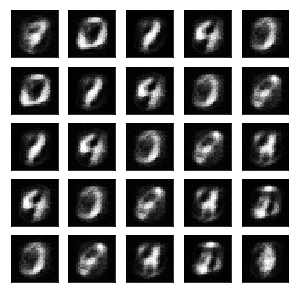

Epoch[14/25], G Loss: -1.2406, D Loss: -2.5633


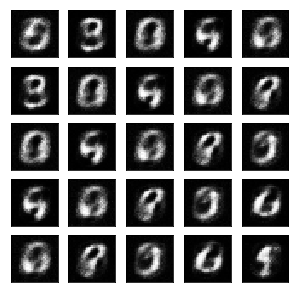

Epoch[15/25], G Loss: -1.2860, D Loss: -2.4491


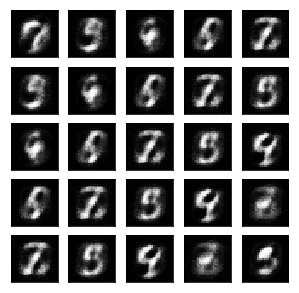

Epoch[16/25], G Loss: -1.3237, D Loss: -2.3425


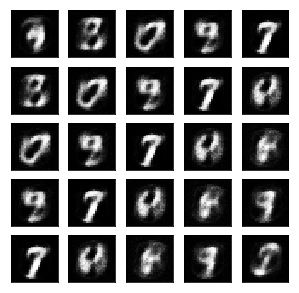

Epoch[17/25], G Loss: -1.3403, D Loss: -2.2416


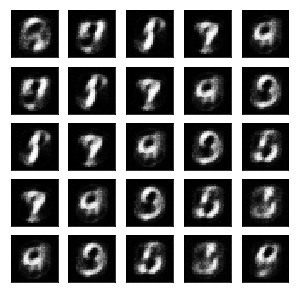

Epoch[18/25], G Loss: -1.3744, D Loss: -2.1615


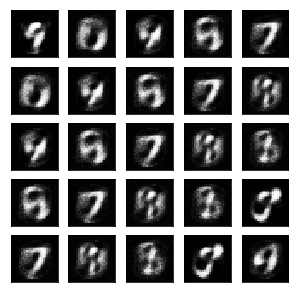

Epoch[19/25], G Loss: -1.4401, D Loss: -2.0809


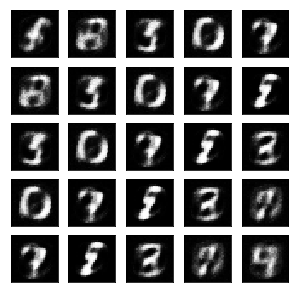

Epoch[20/25], G Loss: -1.4447, D Loss: -2.0198


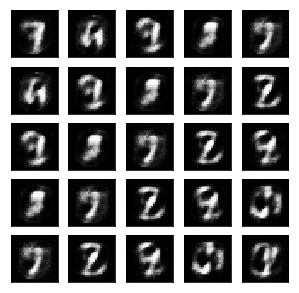

Epoch[21/25], G Loss: -1.4364, D Loss: -1.9603


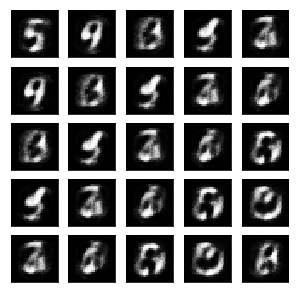

Epoch[22/25], G Loss: -1.3885, D Loss: -1.9159


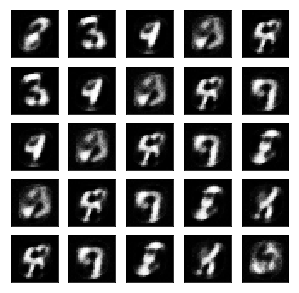

Epoch[23/25], G Loss: -1.4228, D Loss: -1.8566


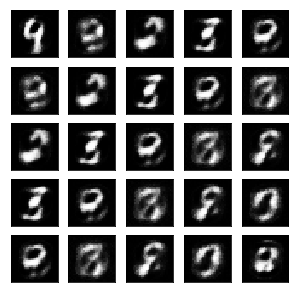

Epoch[24/25], G Loss: -1.3369, D Loss: -1.8127


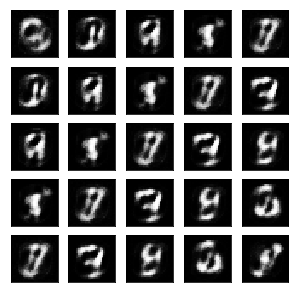

Epoch[25/25], G Loss: -1.3268, D Loss: -1.7663


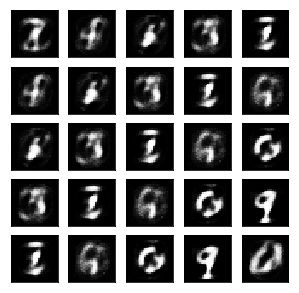

In [3]:
model = WGANGP(image_size = 784, hidden_dim = 256, z_dim = 128) 
if torch.cuda.is_available():
    model = model.cuda()
trainer = Trainer(train_iter, val_iter, test_iter)
model = trainer.train(model = model, num_epochs = 25, G_lr = 1e-4, D_lr = 1e-4, D_steps = 5)